## Title

In the first blog post we saw a simple example of how we can do Bayesian inference, when we have a probabilistic model to describe an atmospheric event or quantity. We used Bayesian inference to estimate the wind speed, which was a "latent variable", a quantity that that controls the observed variables but that can't be directly observed. 

We are interested in more complex models where we might be able to infer the latent variables describing the observed quantities. In this post I will attempt to demonstrate this for a more complex model that is built on differential equations. 


## 1D Linear Convection
A simple place to start is with the 1D Linear convection equation for a travelling wave. Let's assume we know the height of the wave at initialisation at time t=0. Then, we will observe it after time t. During this time, it follows the 1D linear convection equation, which we know and have a model for. To make this more realistic, we might have an imperfect model, and our observations are noisy.

We can use Bayesian inference to infer the speed of the wave, and therefore predict the shape of the full wave and where it will be at some future time, t. 


In [1]:
# libraries
import numpy as np                   
import matplotlib.pyplot as plt  

import time
import torch
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

# seed
np.random.seed(0)

First let's set up the model. I'm assuming that convection is deterministic and using a forward in time, centred in space discretisation for the 1D convection equation (Note: this may not be the most sensible choice but it acts as a model)

In [91]:
def initial_cond(nx, dx, alpha=0.5, beta=1.):
    """ Initialise with a cos wave """
    x = torch.linspace(0.,2.,nx)
    width = beta - alpha
    bell = lambda x: 0.5*(1 - torch.cos(2.*np.pi*(x-alpha)/width))
    h = (torch.where((x<beta) & (x>=alpha), bell(x), torch.tensor(0.)))
    return h

def convect(speed, nu, h, nx, nt, dt, dx):
    """ Returns wave height after nt iterations, given initial height h, 
    following the 1D convection-diffusion equation. Uses finite difference scheme.
    """
    # propagate in time for nt steps, hn is the next step
    hn = torch.zeros(nx)
    for n in range(nt): 
        hn[0] = h[0]
        hn[-1] = h[-1]
        hn[1:-1] = h[1:-1] - speed * dt / (2 * dx) * (h[2:] - h[:-2]) + \
                 nu * (dt / dx**2) * (h[2:] - 2*h[1:-1] + h[:-2])
        # set h to hn for next iteration
        h = hn
    return h

def deterministic_h_model(speed, nu, nx, nt, dt,  alpha=0.5, beta=1.):
    dx = 2 / (nx-1) 
    # initial conditions
    h0 = initial_cond(nx, dx,  alpha, beta)
    # iterate
    true_h = convect(speed, nu, h0, nx, nt, dt, dx)
    return(true_h)

In [113]:
def model(guess, observed_inds, nx, nt, dt,                             
         plot_wave=False):
    """ what are input params  """
    # get pyro distribution of speed, the latent variable
    speed = pyro.sample("speed", dist.Normal(guess, 0.5))
    # 
    nu = pyro.sample("nu", dist.Normal(0.03, 0.01))
    nu = torch.abs(nu)

    true_h = deterministic_h_model(speed, nu, nx, nt, dt)
        
    # observe with some measurement error
    obs_h = torch.zeros(nx)
    for i in pyro.plate("x_axis", nx):
        # each point on the x-axis is conditionally independent given the speed 
        if i in observed_inds:
            obs_h[i] = pyro.sample("h_{}".format(str(i)),
                               dist.Normal(true_h[i],0.01))     
        else:
            obs_h[i] = true_h[i]

    return(speed, nu, obs_h)

As before we will condition on some observations, e.g. we observe the wave at a few points:


Check CFL conds satisfied:
0.3999999999999999
0.125
tensor([0.0000e+00, 1.3643e-09, 1.2732e-08, 9.9337e-08, 6.7141e-07, 3.9511e-06,
        2.0312e-05, 9.1487e-05, 3.6199e-04, 1.2614e-03, 3.8816e-03, 1.0577e-02,
        2.5597e-02, 5.5198e-02, 1.0642e-01, 1.8409e-01, 2.8669e-01, 4.0324e-01,
        5.1363e-01, 5.9373e-01, 6.2365e-01, 5.9543e-01, 5.1635e-01, 4.0601e-01,
        2.8867e-01, 1.8491e-01, 1.0624e-01, 5.4455e-02, 2.4749e-02, 9.9022e-03,
        3.4588e-03, 1.0442e-03, 2.6919e-04, 5.8341e-05, 1.0419e-05, 1.4913e-06,
        1.6435e-07, 1.3083e-08, 6.6916e-10, 1.6506e-11, 0.0000e+00])
[24 19  1 18 35  2  0 33 20  6 10  8 30]
tensor([2.8867e-01, 5.9373e-01, 1.3643e-09, 5.1363e-01, 1.4913e-06, 1.2732e-08,
        0.0000e+00, 5.8341e-05, 6.2365e-01, 2.0312e-05, 3.8816e-03, 3.6199e-04,
        3.4588e-03])


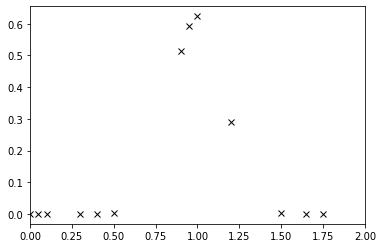

In [114]:
guess = 1.
dx = 2 / (nx-1) 
nx = 41
nt = 20
dt = 0.01
observed_speed = 1.25
observed_nu = 0.05
print("Check CFL conds satisfied:")
print(dt/(0.5*dx**2/observed_nu))
print(dt/(2*observed_nu/observed_speed))
full_observed_h = deterministic_h_model(observed_speed, observed_nu, nx, nt, dt)
print(full_observed_h)

# Pick some random points that we observe
observed_inds = np.random.choice(len(full_observed_h),size=int(nx/3),replace=False)
print(observed_inds)
not_observed_inds = [i for i in range(nx) 
                     if i not in observed_inds]
observed_h = full_observed_h[observed_inds]
print(observed_h)

# Put into data dictionary with named labels
keys = ["h_{}".format(str(i)) for i in observed_inds]
data = dict(zip(keys, observed_h))
# data = {"h_c":observed_h}
# Plot
plt.plot(np.linspace(0,2,nx)[observed_inds],observed_h.detach().numpy(),'kx');
plt.axis(xmin=0.,xmax=2);

Then, we do the conditioning on our data with the following statement:

In [115]:
conditioned_model = pyro.condition(model, data=data)

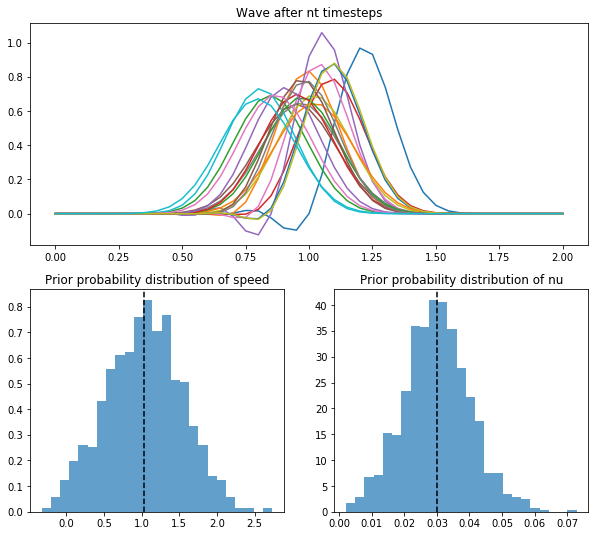

In [116]:
nu_uncond, speed_uncond = [], []
fig = plt.figure(figsize=(10,9));
ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2);
for i in range(1000):
    speed, nu, h = model(guess, [], nx, nt, dt)
    if i < 20:
        plt.plot(np.linspace(0,2,nx),h.detach().numpy())
    nu_uncond.append(nu)
    speed_uncond.append(speed)

plt.title("Wave after nt timesteps")
# Plot probabilistiy distribution of speed
ax1 = plt.subplot2grid((2, 2), (1, 0));
ax1.hist(speed_uncond, 25, density=True, alpha=0.7);
ax1.axvline(np.mean(speed_uncond), c="k", ls="--");
x = np.linspace(0., 2., 100);
plt.title("Prior probability distribution of speed");
#f = 1./(0.5*np.sqrt(2*np.pi))*np.exp(-(x-guess)**2/(2*0.5**2))
#ax1.plot(x,f,color="red")
# Plot probability distribution of nu
ax1 = plt.subplot2grid((2, 2), (1, 1));
ax1.hist(nu_uncond, 25, density=True, alpha=0.7);
ax1.axvline(np.mean(nu_uncond), c="k", ls="--");
x = np.linspace(0., 2., 100);
#f = 1./(0.5*np.sqrt(2*np.pi))*np.exp(-(x-guess)**2/(2*0.5**2))
#ax1.plot(x,f,color="red")
plt.title("Prior probability distribution of nu");

In [109]:
conditioned_model = pyro.condition(model, data=data)

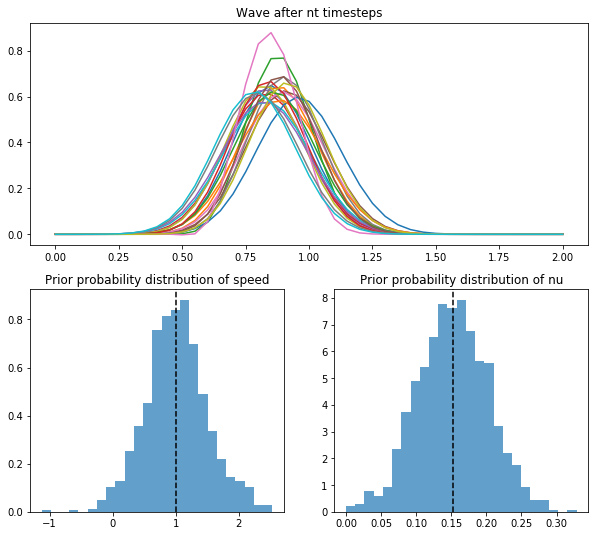

In [77]:
nu_cond, speed_cond = [], []
fig = plt.figure(figsize=(10,9));
ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2);
for i in range(1000):
    speed, nu, h = conditioned_model(guess, [], nx, nt, dt)
    if i < 20:
        plt.plot(np.linspace(0,2,nx),h.detach().numpy())
    nu_cond.append(nu)
    speed_cond.append(speed)

plt.title("Wave after nt timesteps")
# Plot probabilistiy distribution of speed
ax1 = plt.subplot2grid((2, 2), (1, 0));
ax1.hist(speed_cond, 25, density=True, alpha=0.7);
ax1.axvline(np.mean(speed_cond), c="k", ls="--");
x = np.linspace(0., 2., 100);
plt.title("Prior probability distribution of speed");
#f = 1./(0.5*np.sqrt(2*np.pi))*np.exp(-(x-guess)**2/(2*0.5**2))
#ax1.plot(x,f,color="red")
# Plot probability distribution of nu
ax1 = plt.subplot2grid((2, 2), (1, 1));
ax1.hist(nu_cond, 25, density=True, alpha=0.7);
ax1.axvline(np.mean(nu_cond), c="k", ls="--");
x = np.linspace(0., 2., 100);
#f = 1./(0.5*np.sqrt(2*np.pi))*np.exp(-(x-guess)**2/(2*0.5**2))
#ax1.plot(x,f,color="red")
plt.title("Prior probability distribution of nu");

In [88]:
from torch.distributions import constraints

def parameterised_guide(guess, observed_inds, nx, nt, dt,  
                        plot_wave=False):
    # want to infer nu, and h_i at all values that we don't know them at
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(0.25), 
                   constraint=constraints.positive)

    speed = pyro.sample("speed", dist.Normal(a, b))
    
    # want to infer nu, and h_i at all values that we don't know them at
    c = pyro.param("a", torch.tensor(0.5))
    d = pyro.param("b", torch.tensor(0.1), 
                   constraint=constraints.positive)
    
    nu = pyro.sample("nu", dist.Normal(c, d))
    nu = torch.abs(nu)

    true_h = deterministic_h_model(speed, nu, nx, nt, dt)

    h = torch.zeros(nx)
    for i in pyro.plate("x_axis",nx):
        if (i in observed_inds):
            continue 
        else:
            h[i] = (pyro.sample("h_{}".format(str(i)),dist.Normal(true_h[i],0.01)) )
    
    if plot_wave:
        h = torch.detach(h)
        plt.plot(np.linspace(0,2,nx),h.numpy(),'bx')
    
    return(speed, nu, h)



In [86]:
# Plotting function for guide
def plot_guide_wave(guess, observed_h, observed_inds, nx, nt, dt):
    plt.plot(np.linspace(0,2,nx)[observed_inds],
             observed_h.numpy(),'rx',label="Observed");
    not_observed_inds = [i for i in range(nx) 
                         if i not in observed_inds]
    speed, nu,h = parameterised_guide(guess, observed_inds, nx, nt, dt)
    plt.plot(np.linspace(0,2,nx)[not_observed_inds],
             h.detach().numpy()[not_observed_inds],'bx',alpha=0.2,label="Sample");
    for i in range(50):
        speed, nu, h = parameterised_guide(guess, observed_inds,  nx, nt, dt)
        plt.plot(np.linspace(0,2,nx)[not_observed_inds],
             h.detach().numpy()[not_observed_inds],'bx',alpha=0.2);
    plt.axis(xmin=0.,xmax=2);

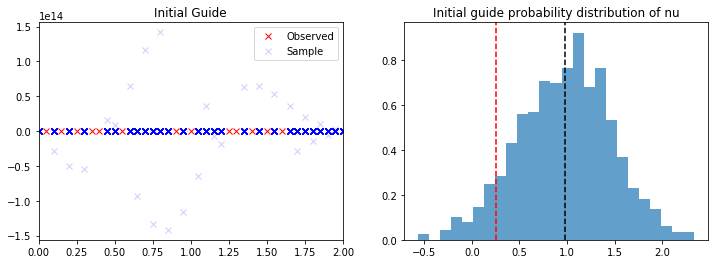

In [89]:
# Check this gives conditioned values fixed
fig = plt.figure(figsize=(12,4));
ax0 = plt.subplot2grid((1, 2), (0, 0));
plot_guide_wave(guess, observed_h, observed_inds, nx, nt, dt)
plt.legend();
nu_guide = [parameterised_guide(guess, observed_inds, nx, nt, dt)[0].item() for i in range(1000)]
plt.title('Initial Guide')
ax1 = plt.subplot2grid((1, 2), (0, 1));
ax1.hist(nu_guide, 25, density=True, alpha=0.7);
ax1.axvline(np.mean(nu_guide), c="k", ls="--",label="Guide");
ax1.axvline(np.mean(observed_nu), c="red", ls="--",label="True observed nu");
plt.title("Initial guide probability distribution of nu");

1.0 [ 8 28 30 25 18  3  1 26 32  7  5 20 11] 41 50 0.001
['a', 'b']
Iteration 0


NameError: name 'true_h_model' is not defined

<Figure size 720x720 with 0 Axes>

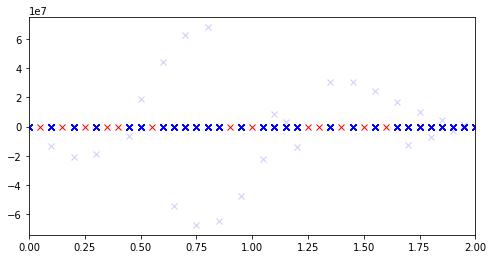

In [90]:
%%time
from pyro.optim import Adam
pyro.clear_param_store()
adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)
svi = pyro.infer.SVI(model=conditioned_model, 
                     guide=parameterised_guide,
                     optim=optimizer,
                     loss=pyro.infer.Trace_ELBO()
                     )

num_steps = 80000
print(guess, observed_inds, nx, nt, dt)
# Save all parameters and losses
svi.step(guess, observed_inds, nx, nt, dt)
param_names = list(pyro.get_param_store().get_all_param_names())
print(param_names)
params = np.zeros((num_steps,len(param_names)))
losses = np.zeros(num_steps)

fig = plt.figure(figsize=(10,10));

plot_ind = 0
for t in range(num_steps):
    losses[t] = svi.step(guess, observed_inds, nx, nt, dt)
    params[t,:] = [pyro.param(param_names[i]).item() for i in range(len(param_names))]
    
    if (t%1000==0.):
        print('Iteration {}'.format(str(t)))
        plt.clf();
        fig = plt.figure(figsize=(8, 4));
        plot_guide_wave(guess, observed_h, observed_inds, nx, nt, dt)
        speed_mean = pyro.param("a").item()
        true_h = true_h_model(speed_mean, nx, nt, dt)
        plt.plot(np.linspace(0,2,nx)[not_observed_inds],
         true_h.numpy()[not_observed_inds], 'kx', lw=2,label="Mean");
        plt.legend();
        plt.title('Iteration {}'.format(str(t)));
        plt.show();
        
fig = plt.figure(figsize=(10, 10));
ax = plt.subplot2grid((2, 5), (1, 0), colspan=4);
ax.plot(losses);
plt.title("ELBO");
plt.xlabel("step");
plt.ylabel("loss");